<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/blob/main/%5BPractice%5D_06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) and [part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.



In [22]:
!nvidia-smi

Fri May 28 16:55:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |   4784MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [23]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-28 16:55:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-28 16:55:42 (105 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [24]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

### Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)).

We download the data as a zip file so we'll use our `unzip_data()` function to unzip it.

In [25]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-05-28 16:55:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  71.3MB/s    in 8.5s    

2021-05-28 16:55:51 (182 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [26]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 

As before our data comes in the common image data format of:

```
# Example of file structure
10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [27]:
# Setup data inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)
train_data_all_classes_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMAGE_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


 ## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

Following is the modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data


Let's start by creating the `ModelCheckpoint` callback. 

Since we want our model to perform well on unseen data we'll set it to monitor the `validation accuracy` metric and save the model weights which score the best on that.

In [28]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         monitor = 'val_accuracy',
                                                         save_weights_only=True, 
                                                         save_best_only=True)

In [29]:
# Create data augmentation layer to incorporate it directly to model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation_layer = Sequential([
                          preprocessing.RandomFlip("horizontal"),
                          preprocessing.RandomHeight(0.2),
                          preprocessing.RandomWidth(0.2),
                          preprocessing.RandomZoom(0.2),
                          preprocessing.RandomRotation(0.2)
                          # preprocessing.Rescaling(1/255.) # rescale input images between 0-1 required for models like resnet50
], name = "data_augmentation_layer")

In [30]:
# Build a headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model and freeze all layers

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

INPUT_SHAPE = (224,224,3)
# Assemble the whole model with trainable top layer
inputs = layers.Input(shape = INPUT_SHAPE, name = 'input_layer')
x = data_augmentation_layer(inputs) # augment images (happens only during training phase)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x) # put the base model in inference mode so we can use it to extract features without updating the weights
outputs = layers.Dense(len(train_data_all_classes_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)


In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [32]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [33]:
history_all_classes_10_per_feature_extraction = model.fit(train_data_all_classes_10_percent,
                                                steps_per_epoch = len(train_data_all_classes_10_percent),
                                                epochs = 5,
                                                validation_data = test_data, 
                                                validation_steps = int(0.15 * len(test_data)),
                                                callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 62s 237ms/step - loss: 3.4854 - accuracy: 0.2451 - val_loss: 2.6938 - val_accuracy: 0.4081
Epoch 2/5
237/237 [==============================] - 53s 222ms/step - loss: 2.3814 - accuracy: 0.4519 - val_loss: 2.2574 - val_accuracy: 0.4688
Epoch 3/5
237/237 [==============================] - 52s 219ms/step - loss: 1.9972 - accuracy: 0.5307 - val_loss: 2.0694 - val_accuracy: 0.4828
Epoch 4/5
237/237 [==============================] - 50s 209ms/step - loss: 1.7891 - accuracy: 0.5666 - val_loss: 1.9823 - val_accuracy: 0.5016
Epoch 5/5
237/237 [==============================] - 51s 215ms/step - loss: 1.6490 - accuracy: 0.6015 - val_loss: 1.9588 - val_accuracy: 0.4931


In [34]:
feature_extraction_results_10_percent = model.evaluate(test_data)
feature_extraction_results_10_percent

790/790 [==============================] - 87s 111ms/step - loss: 1.7184 - accuracy: 0.5530


[1.718396782875061, 0.5529900789260864]

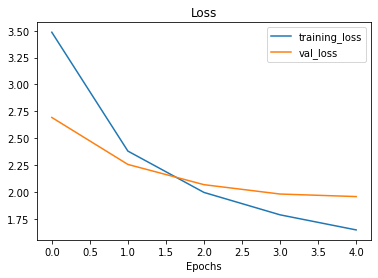

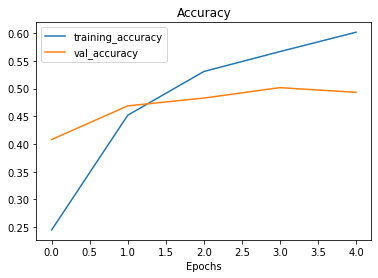

In [35]:
plot_loss_curves(history_all_classes_10_per_feature_extraction)

### Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [36]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Freeze all layers except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [37]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ['accuracy'])

In [38]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [39]:
# check what layers our trainable in our base model
for idx,layer in enumerate(model.layers[2].layers):
  print(idx, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
# Fine tune for 5 more epochs
FINE_TUNE_EPOCHS = 10
history_all_classes_10_per_fine_tune = model.fit(train_data_all_classes_10_percent,
                                                 steps_per_epoch = len(train_data_all_classes_10_percent),
                                                 epochs = FINE_TUNE_EPOCHS,
                                                 validation_data = test_data,
                                                 validation_steps = int(0.15 * len(test_data)),
                                                 initial_epoch = history_all_classes_10_per_feature_extraction.epoch[-1])

Epoch 5/10
237/237 [==============================] - 59s 220ms/step - loss: 1.3965 - accuracy: 0.6434 - val_loss: 1.9225 - val_accuracy: 0.5050
Epoch 6/10
237/237 [==============================] - 51s 214ms/step - loss: 1.2838 - accuracy: 0.6626 - val_loss: 1.8643 - val_accuracy: 0.5159
Epoch 7/10
237/237 [==============================] - 49s 204ms/step - loss: 1.1839 - accuracy: 0.6878 - val_loss: 1.8512 - val_accuracy: 0.5246
Epoch 8/10
237/237 [==============================] - 49s 207ms/step - loss: 1.1349 - accuracy: 0.6945 - val_loss: 1.8771 - val_accuracy: 0.5180
Epoch 9/10
237/237 [==============================] - 48s 203ms/step - loss: 1.0774 - accuracy: 0.7105 - val_loss: 1.8497 - val_accuracy: 0.5212
Epoch 10/10
237/237 [==============================] - 47s 195ms/step - loss: 1.0147 - accuracy: 0.7321 - val_loss: 1.8285 - val_accuracy: 0.5254


In [45]:
fine_tune_results_10_percent = model.evaluate(test_data)
fine_tune_results_10_percent

790/790 [==============================] - 86s 109ms/step - loss: 1.5861 - accuracy: 0.5813


[1.5861480236053467, 0.5813465118408203]

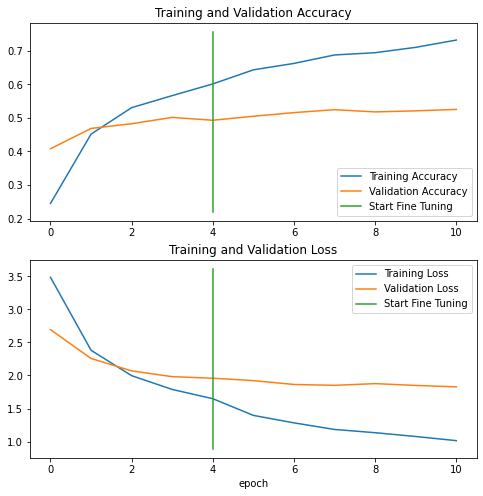

In [46]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_per_feature_extraction,
                 new_history = history_all_classes_10_per_fine_tune,
                 initial_epochs = 5)

### Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [47]:
model.save('/content/drive/MyDrive/Food_Classification/saved_models/101_food_class_10_percent_saved_big_dog_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/101_food_class_10_percent_saved_big_dog_model/assets


In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Food_Classification/saved_models/101_food_class_10_percent_saved_big_dog_model')

In [49]:
# evaluate saved model
loaded_model_results_10_percent = loaded_model.evaluate(test_data)
loaded_model_results_10_percent

790/790 [==============================] - 88s 110ms/step - loss: 1.5861 - accuracy: 0.5813


[1.5861480236053467, 0.5813465118408203]

In [50]:
fine_tune_results_10_percent

[1.5861480236053467, 0.5813465118408203]

## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics can be deceiving, let's dive a little deeper into our model's performance and get some predictions on test data.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.


In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Food_Classification/saved_models/101_food_class_10_percent_saved_big_dog_model')
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [54]:
# Evaluate model we just loaded on test data to verify that it has been loaded correctly
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 90s 112ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [73]:
# Making predictions using our trained model
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 61s 77ms/step


In [74]:
pred_probs[0]

array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
       8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
       1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
       2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
       6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
       1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
       8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
       2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
       1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
       1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
       8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
       2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
       3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
       8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
       3.5306231e-05, 3.2489133e-05, 6.7314817e-05, 1.2852616e

In [75]:
len(pred_probs)

25250

In [76]:
pred_probs.shape

(25250, 101)

In [77]:
pred_probs[0].shape

(101,)

In [78]:
tf.argmax(pred_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=52>

In [79]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [80]:
test_data.class_names[52]

'gyoza'

In [82]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")
print(f"Predicted label for sample 0 is {test_data.class_names[pred_probs[0].argmax()]}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542008e-02 3.5741950e-06 4.1376859e-02 1.0660556e-09 8.1613978e-09
 8.6639664e-09 8.0926822e-07 8.5652499e-07 1.9859017e-05 8.0977776e-07
 3.1727747e-09 9.8673661e-07 2.8532164e-04 7.8049051e-10 7.4230169e-04
 3.8916416e-05 6.4740193e-06 2.4977280e-06 3.7891099e-05 2.0678388e-07
 1.5538422e-05 8.1506943e-07 2.6230446e-06 2.0010630e-07 8.3827456e-07
 5.4215989e-06 3.7390860e-06 1.3150533e-08 2.7761406e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688865e-04 7.6407297e-10 4.0452729e-04
 1.3150634e-08 1.7957379e-06 1.4448218e-06 2.3062859e-02 8.2466784e-07
 8.5365781e-07 1.7138614e-06 7.0525107e-06 1.8402169e-08 2.8553407e-07
 7.9483234e-06 2.0681514e-06 1.8525066e-07 3.3619774e-08 3.1522498e-04
 1.0410913e-05 8.5448539e-07 8.4741873e-01 1.0555415e-05 4.4094671e-07
 3.7404148e-05 3.5306231e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219660e-10 1.0318080e-05 8.5744046e-05 1.

In [83]:
pred_classes = pred_probs.argmax(axis = 1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [84]:
len(pred_classes)

25250

We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

> 🔑 **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [86]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [87]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [88]:
# How many y labels are there?
len(y_labels)

25250

In [92]:
np.unique(y_labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [96]:
import pandas as pd
pd.value_counts(y_labels)[:10]

95    250
21    250
83    250
99    250
4     250
20    250
36    250
52    250
68    250
84    250
dtype: int64

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [97]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [99]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)

In [100]:
sklearn_accuracy

0.6077623762376237

In [102]:
# Does this metric come close to our accuracy using `evaluate()`
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

since both the accuracies are similar hence we can assume that the labels are in order.